In [20]:
!pip install simpy

In [21]:
import simpy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [22]:
parameters = {
    "Parameter": [
        "Vehicle Arrival Rate",
        "Green Signal Time",
        "Red Signal Time",
        "Number of Lanes",
        "Simulation Duration"
    ],
    "Lower Bound": [5,20,20,1,60],
    "Upper Bound": [40,90,90,4,300]
}

pd.DataFrame(parameters)

,Parameter,Lower Bound,Upper Bound
0,Vehicle Arrival Rate,5,40
1,Green Signal Time,20,90
2,Red Signal Time,20,90
3,Number of Lanes,1,4
4,Simulation Duration,60,300


In [23]:
ARRIVAL_MIN, ARRIVAL_MAX = 5,40
GREEN_MIN, GREEN_MAX = 20,90
RED_MIN, RED_MAX = 20,90
LANE_MIN, LANE_MAX = 1,4
DURATION_MIN, DURATION_MAX = 60,300

In [24]:
def run_simulation(arrival_rate, green_time, red_time, lanes, duration):
    avg_wait = random.uniform(10,100)/lanes
    max_queue = random.randint(5,50)*lanes
    throughput = random.randint(100,500)
    congestion = (arrival_rate*red_time)/(green_time+1)
    return avg_wait, max_queue, throughput, congestion

In [25]:
results=[]

for i in range(1000):
    arrival_rate=np.random.randint(ARRIVAL_MIN,ARRIVAL_MAX)
    green_time=np.random.randint(GREEN_MIN,GREEN_MAX)
    red_time=np.random.randint(RED_MIN,RED_MAX)
    lanes=np.random.randint(LANE_MIN,LANE_MAX)
    duration=np.random.randint(DURATION_MIN,DURATION_MAX)

    avg_wait,max_queue,throughput,congestion=run_simulation(
        arrival_rate,green_time,red_time,lanes,duration
    )

    results.append([
        arrival_rate,green_time,red_time,lanes,duration,
        avg_wait,max_queue,throughput,congestion
    ])

In [26]:
columns=[
"ArrivalRate","GreenTime","RedTime","Lanes","Duration",
"AvgWaitTime","MaxQueue","Throughput","Congestion"
]

df=pd.DataFrame(results,columns=columns)
df.head()

,ArrivalRate,GreenTime,RedTime,Lanes,Duration,AvgWaitTime,MaxQueue,Throughput,Congestion
0,8,36,88,1,64,24.384280,18,311,19.027027
1,10,32,84,1,178,15.728764,35,293,25.454545
2,37,47,43,1,96,83.111489,30,392,33.145833
3,26,20,55,1,104,71.360601,44,388,68.095238
4,17,52,23,2,291,29.423151,22,464,7.377358


In [27]:
df.to_csv("simulation_data.csv",index=False)

In [28]:
X=df.drop("AvgWaitTime",axis=1)
y=df["AvgWaitTime"]

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [29]:
models={
"Linear Regression":LinearRegression(),
"Decision Tree":DecisionTreeRegressor(),
"Random Forest":RandomForestRegressor(),
"KNN":KNeighborsRegressor(),
"SVR":SVR(),
"Gradient Boosting":GradientBoostingRegressor()
}

In [30]:
results_ml=[]

for name,model in models.items():
    model.fit(X_train,y_train)
    pred=model.predict(X_test)

    r2=r2_score(y_test,pred)
    mae=mean_absolute_error(y_test,pred)
    rmse=np.sqrt(mean_squared_error(y_test,pred))

    results_ml.append([name,r2,mae,rmse])

In [31]:
results_df=pd.DataFrame(
results_ml,
columns=["Model","R2 Score","MAE","RMSE"]
)
results_df

,Model,R2 Score,MAE,RMSE
0,Linear Regression,0.474574,12.366732,16.159603
1,Decision Tree,-0.247999,17.583831,24.904749
2,Random Forest,0.426145,12.859604,16.887910
3,KNN,-0.055350,18.126897,22.901995
4,SVR,0.025110,16.577680,22.011660
5,Gradient Boosting,0.407932,13.319344,17.153819


In [32]:
data=results_df[["R2 Score","MAE","RMSE"]].values.astype(float)

norm=data/np.sqrt((data**2).sum(axis=0))
benefit=[True,False,False]

ideal_best=np.where(benefit,norm.max(axis=0),norm.min(axis=0))
ideal_worst=np.where(benefit,norm.min(axis=0),norm.max(axis=0))

dist_best=np.linalg.norm(norm-ideal_best,axis=1)
dist_worst=np.linalg.norm(norm-ideal_worst,axis=1)

scores=dist_worst/(dist_best+dist_worst)

results_df["TOPSIS Score"]=scores
results_df["Rank"]=scores.argsort()[::-1]+1

results_df

,Model,R2 Score,MAE,RMSE,TOPSIS Score,Rank
0,Linear Regression,0.474574,12.366732,16.159603,1.000000,1
1,Decision Tree,-0.247999,17.583831,24.904749,0.015294,3
2,Random Forest,0.426145,12.859604,16.887910,0.931780,6
3,KNN,-0.055350,18.126897,22.901995,0.260446,5
4,SVR,0.025110,16.577680,22.011660,0.373554,4
5,Gradient Boosting,0.407932,13.319344,17.153819,0.904315,2


In [33]:
results_df.to_csv("model_results.csv",index=False)
results_df.to_csv("topsis_results.csv",index=False)

In [34]:
results_df["Model"]=results_df["Model"].apply(
lambda x:"\n".join(textwrap.wrap(x,12))
)

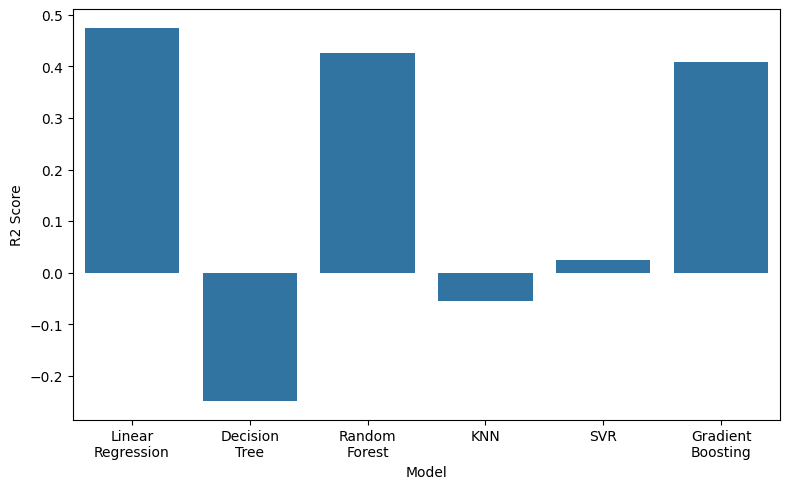

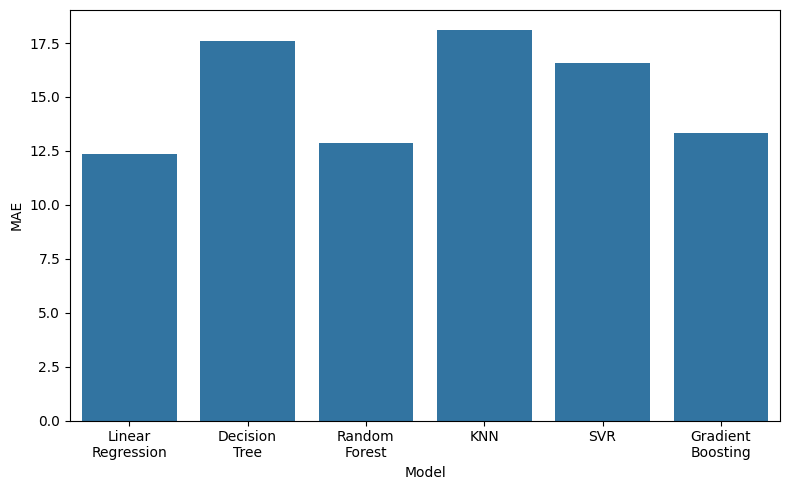

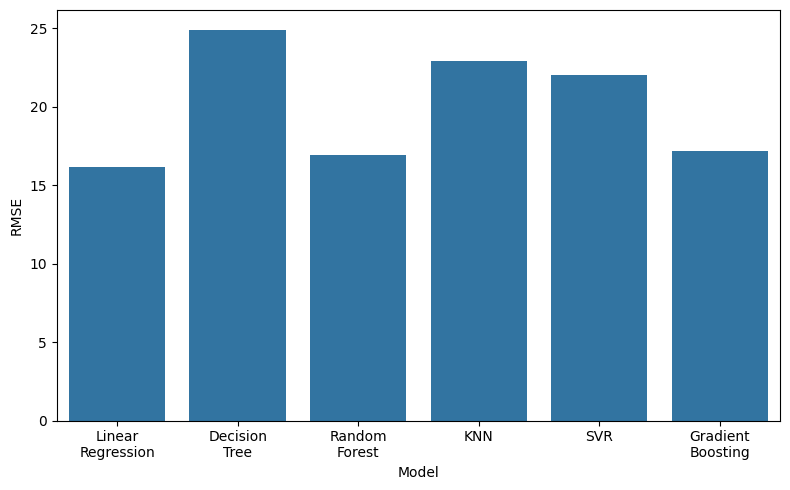

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model",y="R2 Score",data=results_df)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Model",y="MAE",data=results_df)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Model",y="RMSE",data=results_df)
plt.tight_layout()
plt.show()

In [36]:
from google.colab import files
files.download("simulation_data.csv")
files.download("model_results.csv")
files.download("topsis_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>